# Imports

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import os
import math
from scipy.ndimage import gaussian_filter
from sklearn.preprocessing import OneHotEncoder
import random
from keras.utils.np_utils import to_categorical   
from tensorflow.keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from sklearn.neighbors import KNeighborsClassifier

# Some Basic Functions

In [ ]:
def plotSpectrogram(comp ,mat , title1 , mat2= None , title2=None ) :
  if comp == False :
    plt.pcolor(mat , cmap = 'plasma')
    plt.title(title1)
    plt.show()
  else :
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1) 
    plt.pcolor(mat , cmap = 'plasma')
    plt.title(title1)
    plt.subplot(1,2,2)
    plt.pcolor(mat2 , cmap = 'plasma')
    plt.title(title2)
    plt.show()

In [ ]:
def addDim(mat) :
  return np.expand_dims(mat , axis = 2)
def reduceDim(mat) :
  return mat[0]

**Data Loader**

Returns list of Numpy arrays and list of labels

In [ ]:
def load_data(data_csv_path , dataset_path) :
  X = []
  Y = []
  data = pd.read_excel(data_csv_path)
  for i in range(data.shape[0]) :
    npMat = np.load(os.path.join(dataset_path , data['fname'][i]))
    X.append(npMat)
    Y.append(data['label'][i])
  return X,Y

# **Data Visualisation**

In [ ]:
X, Y = load_data("/content/drive/MyDrive/mlsp/annotations.xlsx" , "/content/drive/MyDrive/mlsp/data_train/train")

Ploting N spectrograms from each class

In [ ]:
def visualise(N , X, Y ,X1 = None, Y1 = None) :
  total_samples = N*10
  for i in np.linspace(0,len(X)-1 , total_samples) :
    i = int(i)
    if X1 == None :
      plotSpectrogram(False ,reduceDim(X[i].copy()) , Y[i])
    else :
      plotSpectrogram(True ,reduceDim(X[i].copy()) , Y[i] , reduceDim(X1[i].copy()) , Y1[i] )    

Here , N=1 

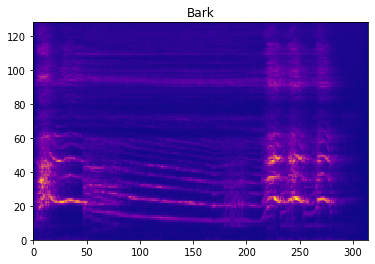

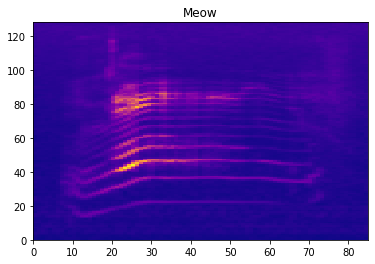

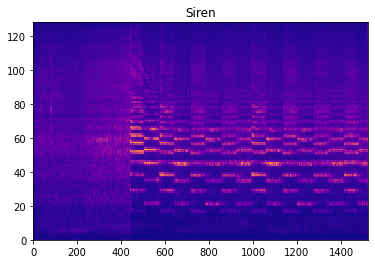

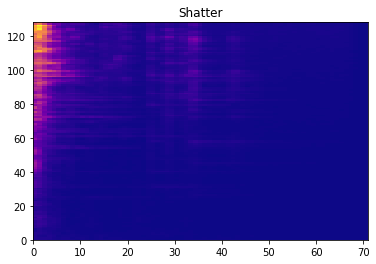

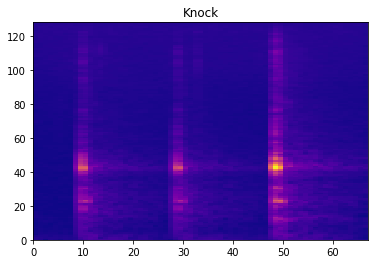

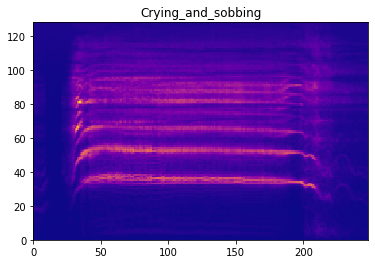

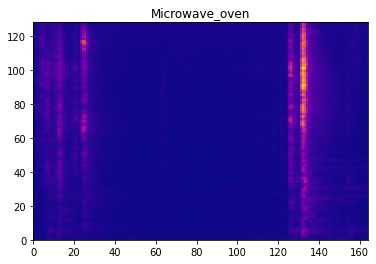

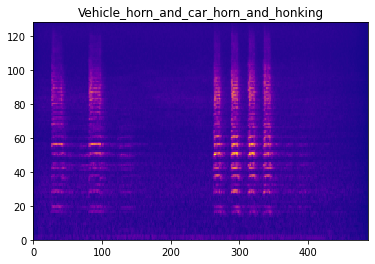

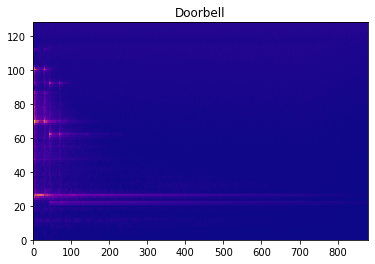

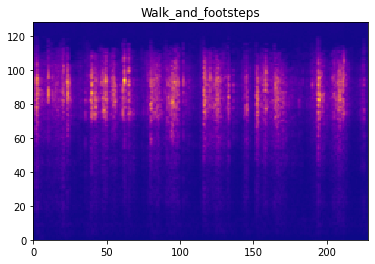

In [ ]:
visualise(1 , X, Y)

# **Preprocessing**
**Observation** : In spectrogram of each class, there is a repetion of specific pattern over time and many columns of the matrix are zero/close to zero.

**Methods** - 

1.   Extract K number of columns, in descending order, on the basis of the sum of the values present in the column and form a new matrix of size 128 x K , while conserving the order in which column were present in the original matrix.
2.  Of all the repeated patterns, take only 1 pattern and form a new matrix of size 128 x K .This is implemented by choosing submatrix of dimension 128 X K which has maximum cross-correaltion with the original matrix. 



**Method 1** 

Param : 
  
  mat : 2D numpy array
  
  K : last column which is to be choosen (in descending order of sum of column values)

  i : First column which is to be choosen (in descending order of sum of column values)


Returns processed 2D array of size 128 x (K - i)

In [ ]:
def preprocess1(mat , K = 64, i = 0):
  if mat.shape[1] < K :
    mat = np.concatenate((mat , np.zeros((128 , K - mat.shape[1]))) , axis = 1)
  mat = mat.T
  a = []
  for t in range(mat.shape[0]) :
    a.append(np.sum(mat[t])/128)
  a = list(enumerate(a))
  a.sort(key = lambda x:x[1])
  a = np.flip(a)
  b = a[i:K]
  b = sorted(b,key = lambda x:x[1])
  ans = np.array([])
  ans = np.resize(ans , (128,1))
  for p in range(K):
    try :
      ans = np.concatenate((ans , np.expand_dims(mat[int(b[p][1])] , axis =1)) , axis = 1)
    except :
      print(t)
  return ans

**Method 2**


In [ ]:
def cross_corr(mat1 , mat2) :
  sum = 0
  w1 = mat1.shape[1]
  w2 = mat2.shape[1]
  mat1 = mat1.T
  mat2 = mat2.T
  lim = w2 - w1 + 1
  for i in range(lim) :
    sum += (np.sum(np.multiply(mat1 , mat2[i:i+w1])))
  mat1 = mat1.T
  mat2 = mat2.T
  return sum

def preprocess2(mat , width) :
  if mat.shape[1] < width :
    mat = np.concatenate((mat , np.zeros((128 , width - mat.shape[1]))) , axis = 1)
  sums = []
  lim = mat.shape[1] - width + 1
  for i in range(lim) :
    sums.append(cross_corr((mat.T)[i:i+width].T, mat))
  sums = list(enumerate(sums))
  sums.sort(key = lambda x : x[1])
  sums.reverse()
  idx = sums[0][0]
  return ((mat.T)[idx:idx+width]).T

Faster Implementation of Method 2

In [ ]:
def cross_corr_1d(arr1 , arr2) :
  l1 = arr1.shape[0]
  l2 = arr2.shape[0]
  lim = l2 - l1 +1
  sum = 0
  for i in range(lim) :
    sum += np.sum(np.multiply(arr1, arr2[i:i+l1]))
  return sum 

def preprocess3(mat , width) :
    if mat.shape[1] < width :
      mat = np.concatenate((mat , np.zeros((128 , width - mat.shape[1]))) , axis = 1)
    sums= []
    lim = mat.shape[1] - width + 1
    mat_copy = []
    mat = mat.T
    for i in range(mat.shape[0]) :
      mat_copy.append(np.sum(mat[i]))
    
    mat_1D = np.array(mat_copy)
    mat = mat.T

    for j in range(lim) :
      sums.append(cross_corr_1d(mat_1D[j:j+width], mat_1D))
    sums = list(enumerate(sums))
    sums.sort(key = lambda x : x[1])
    sums.reverse()
    idx = sums[0][0]

    return ((mat.T)[idx:idx+width]).T 


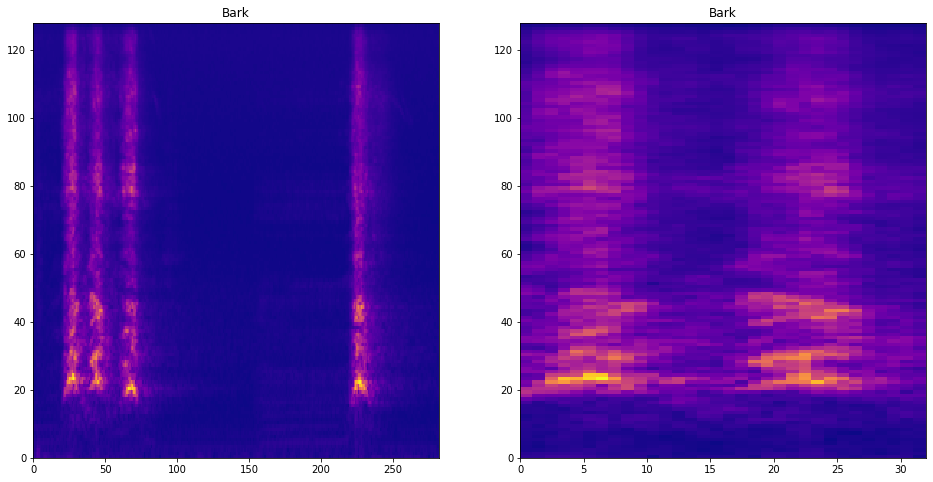

In [15]:
for i in np.linspace(0,1000,1) :
  i = 32
  r = reduceDim(X[i].copy())
  # s = preprocess1(r, K= 32)
  # t = preprocess2(r, 32)
  q = preprocess3(r, 32)
  # plotSpectrogram(True , r, Y[800] , s , Y[800])
  # plotSpectrogram(True , r, Y[800] , t , Y[800])
  plotSpectrogram(True , r, Y[i] , q , Y[i])


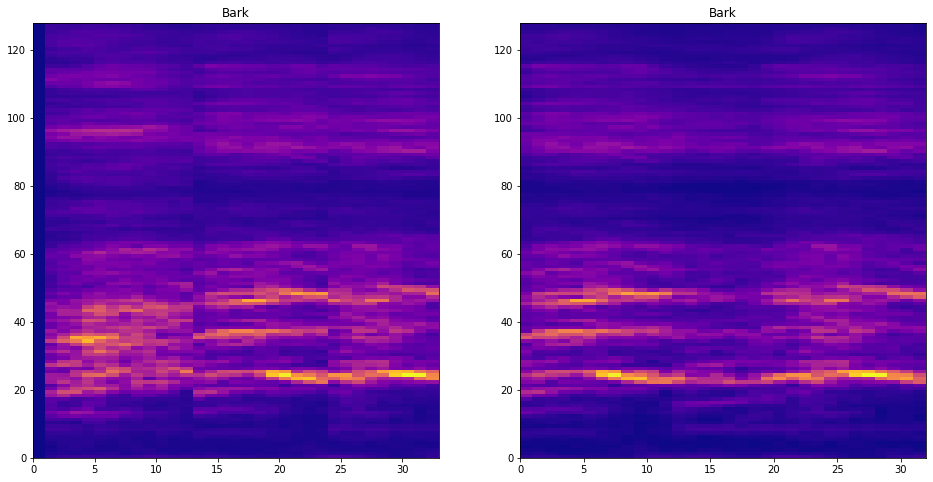

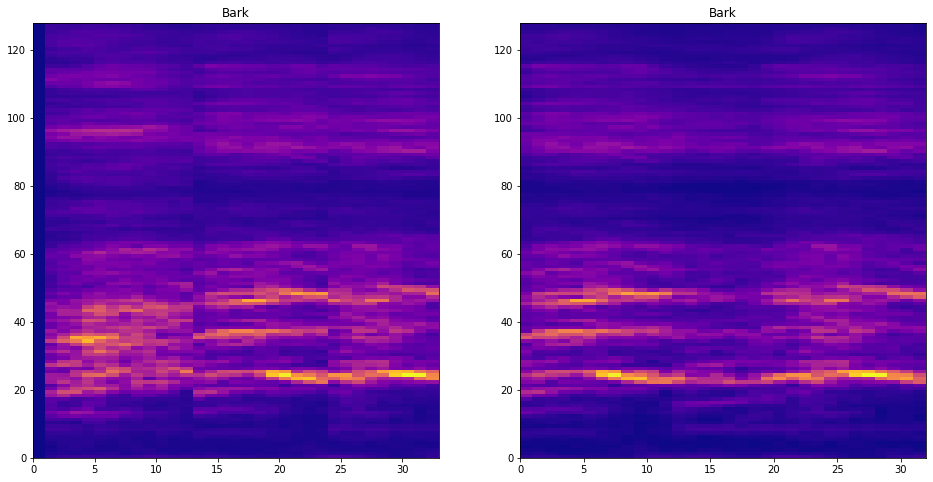

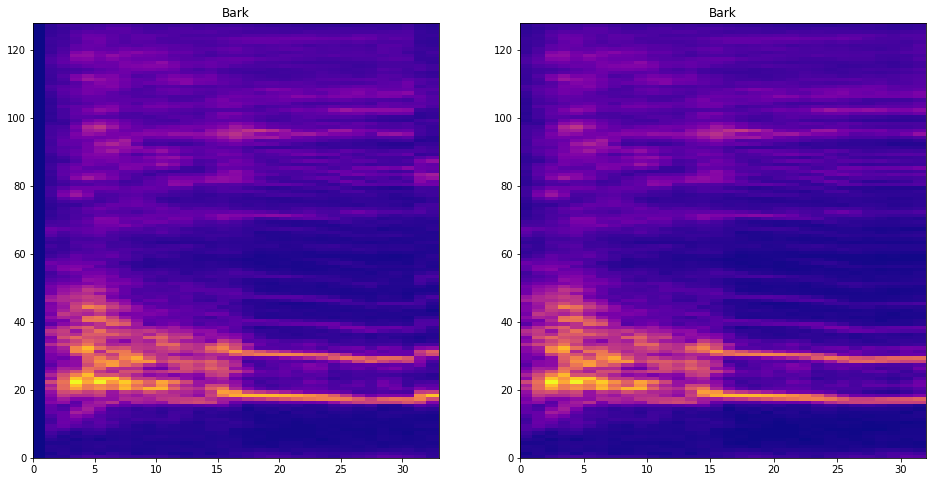

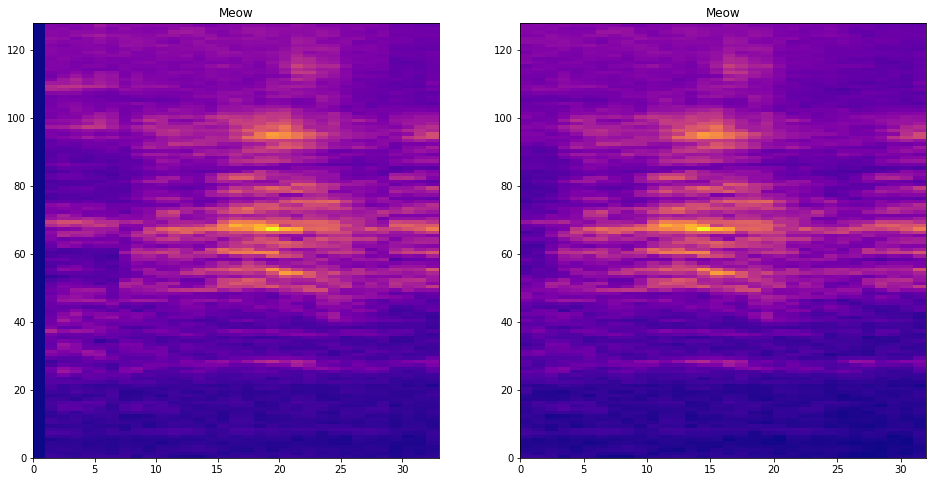

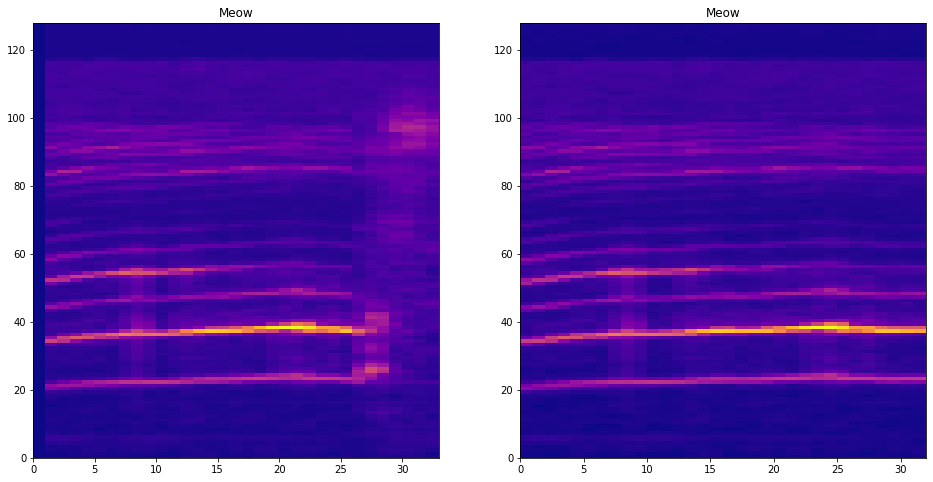

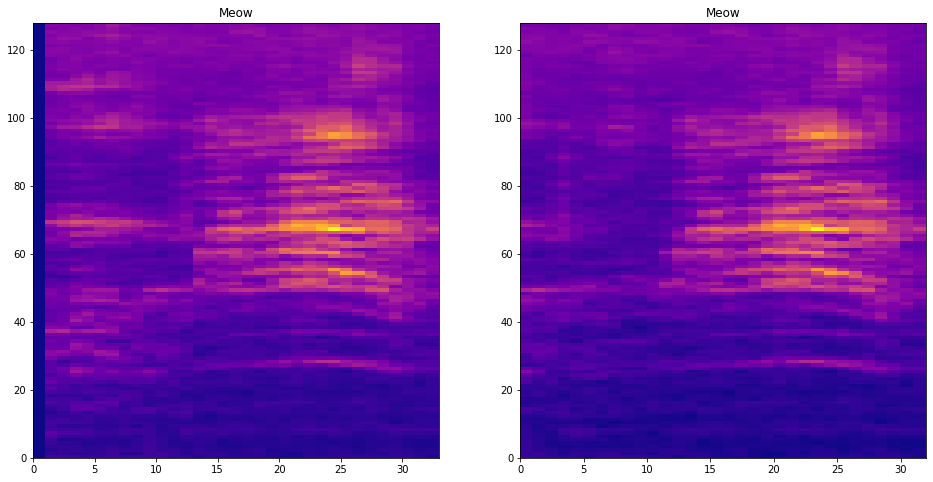

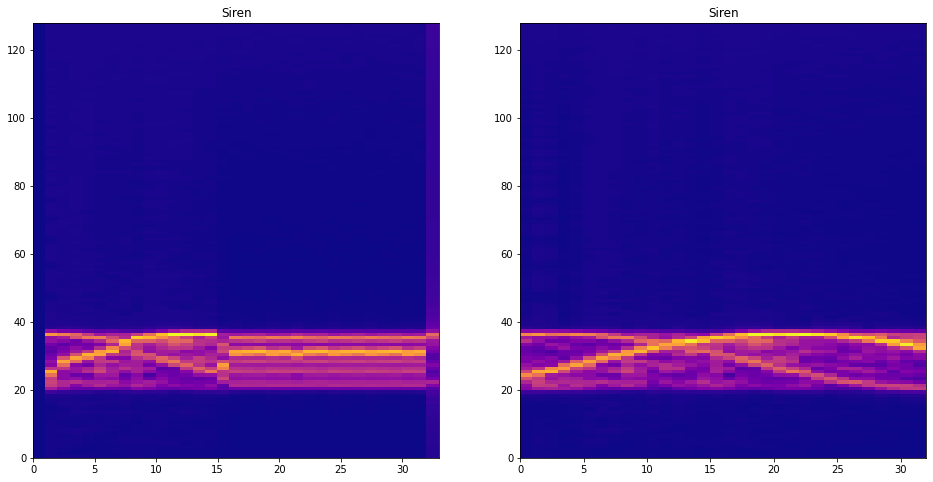

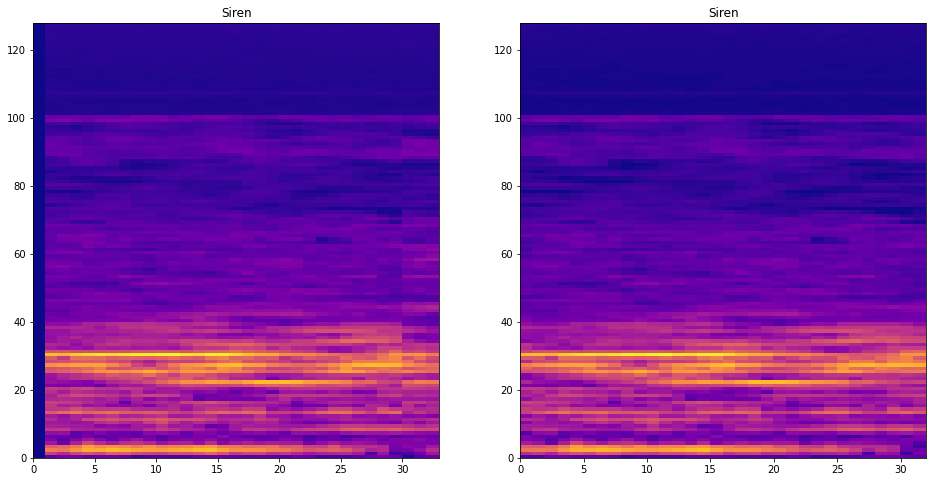

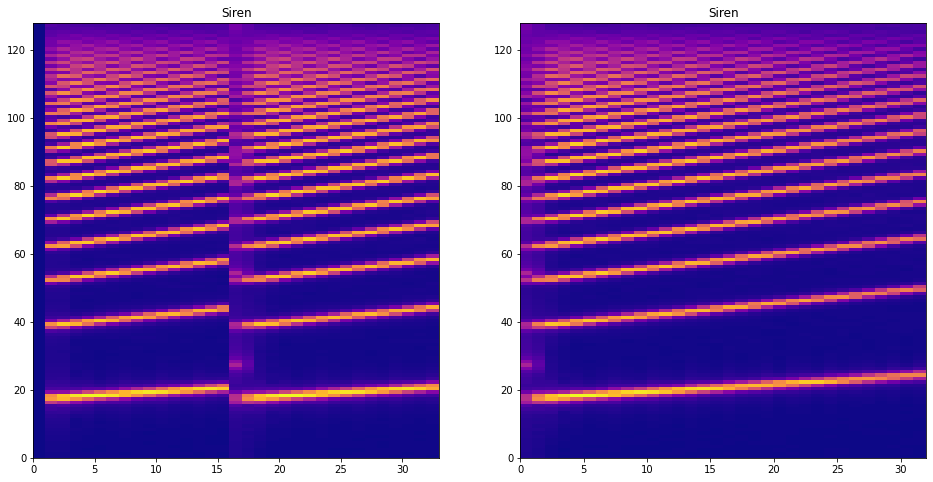

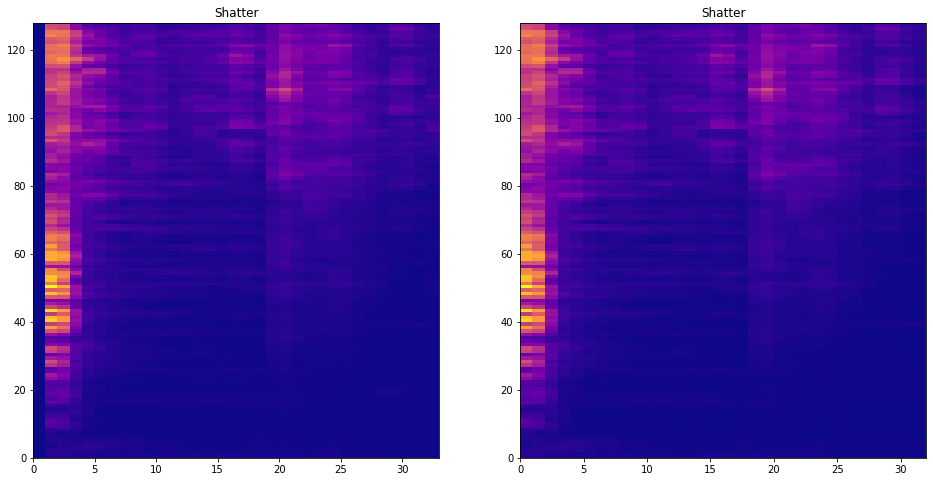

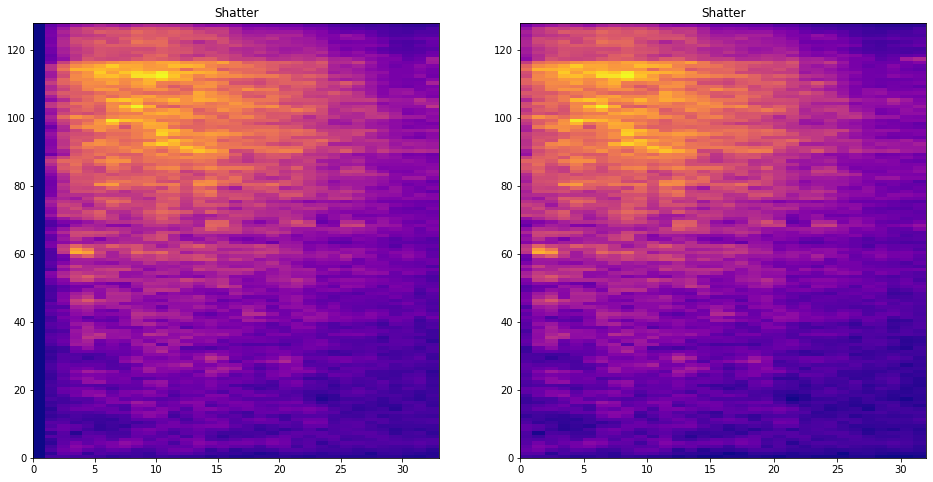

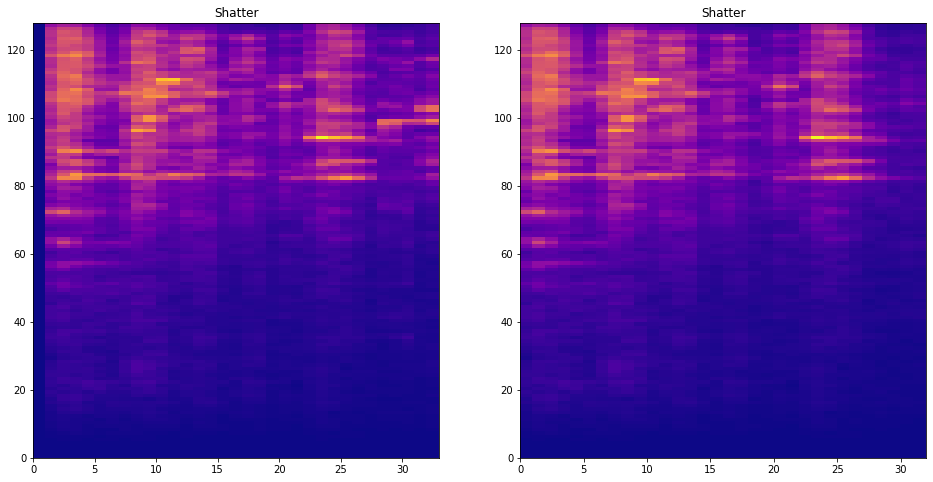

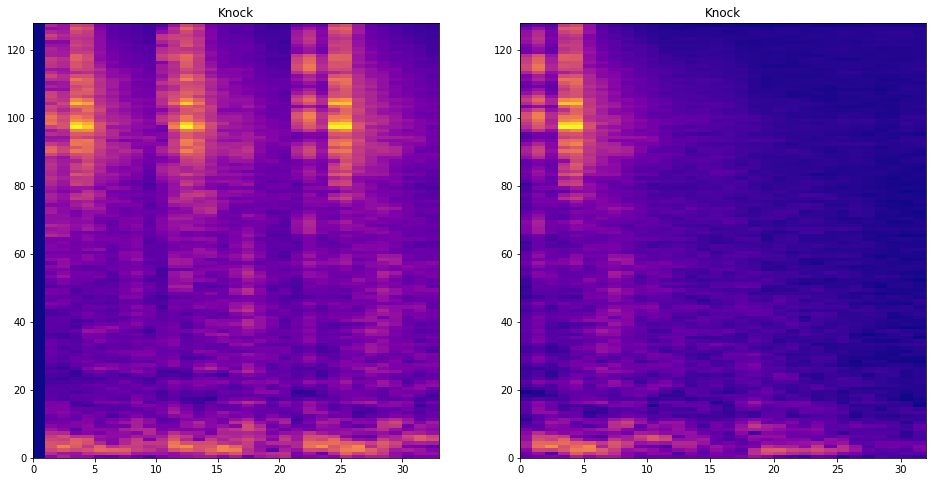

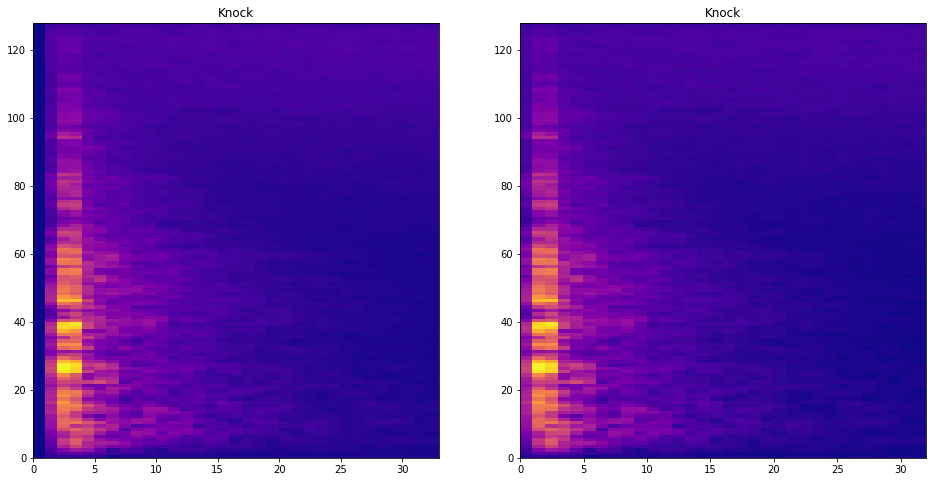

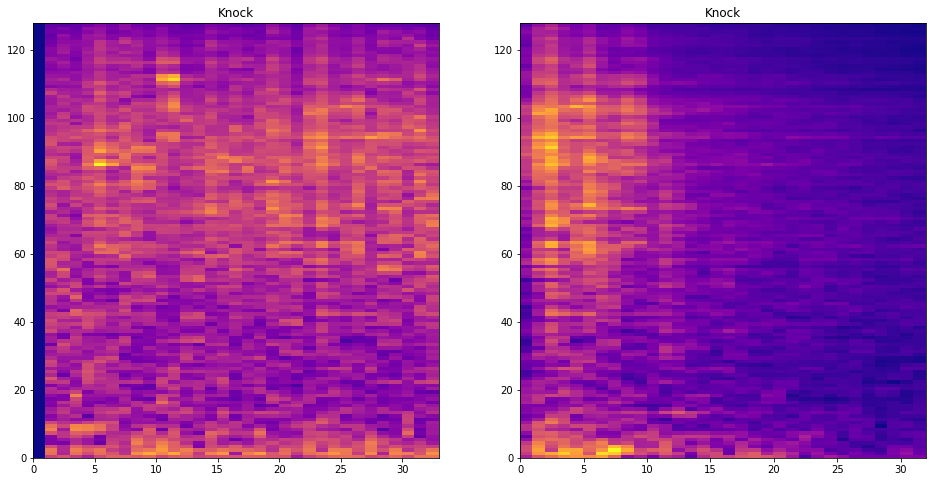

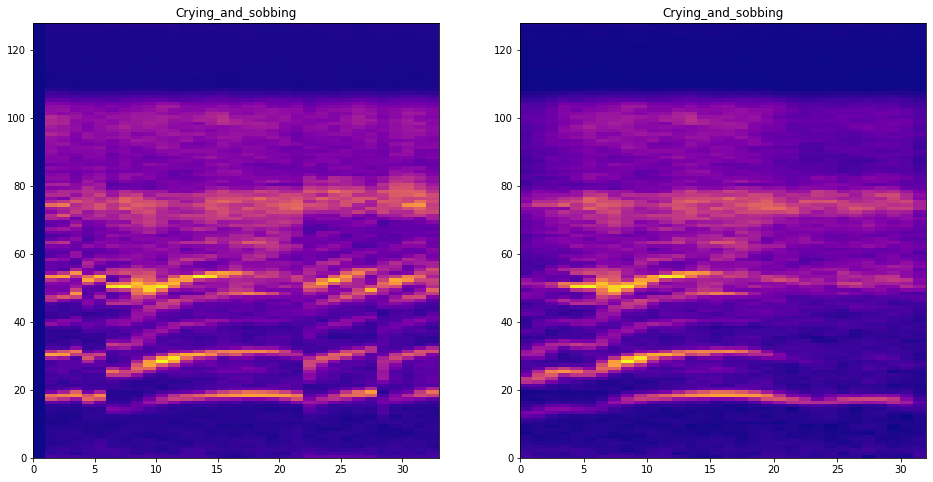

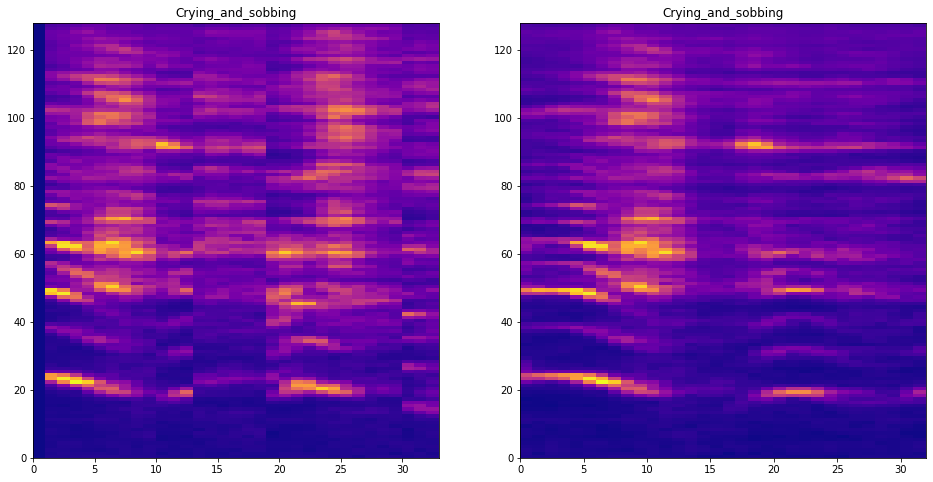

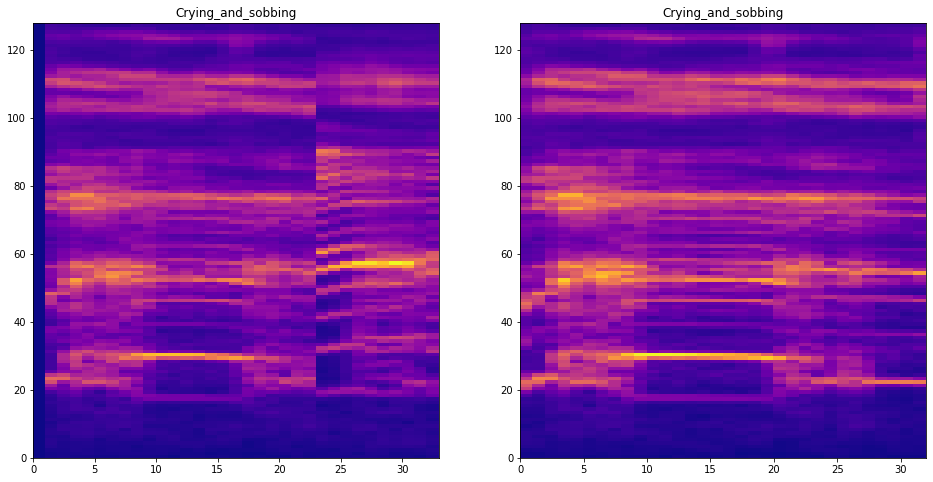

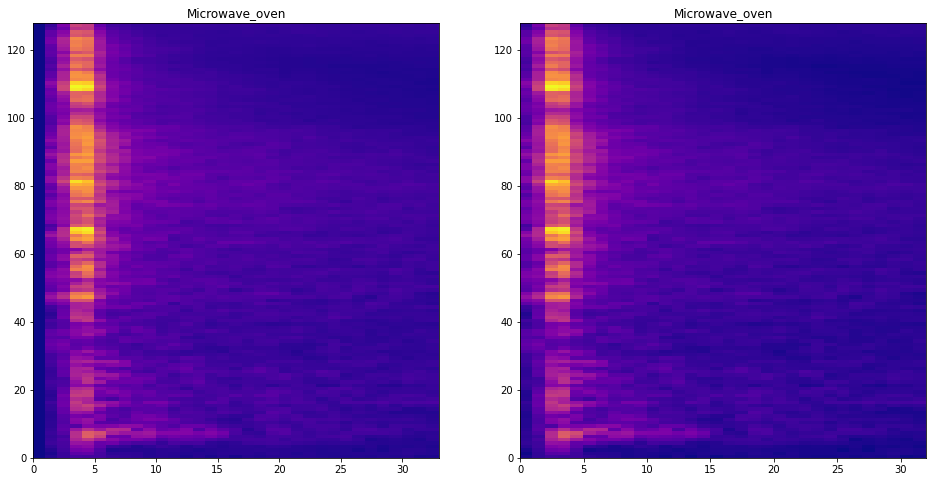

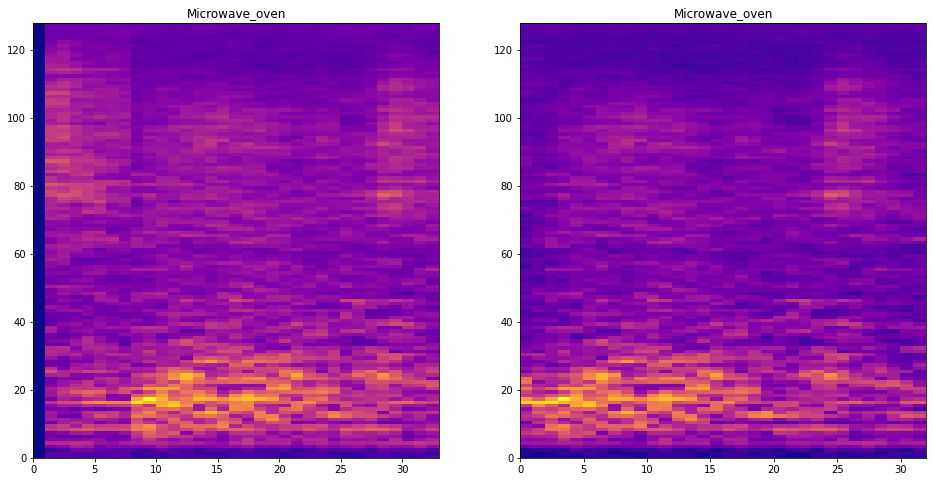

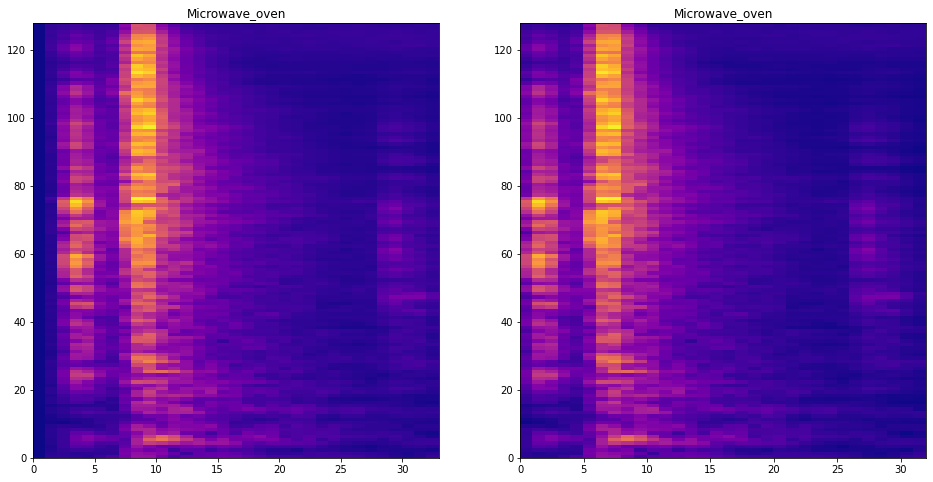

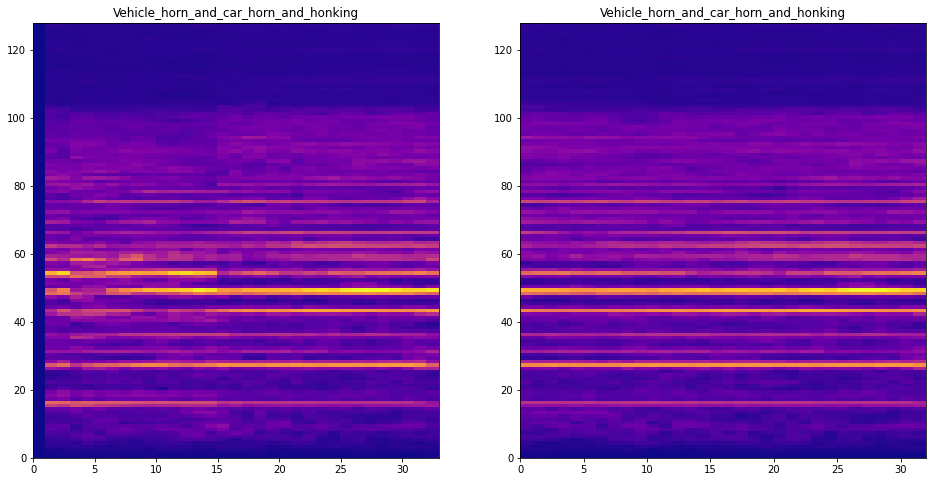

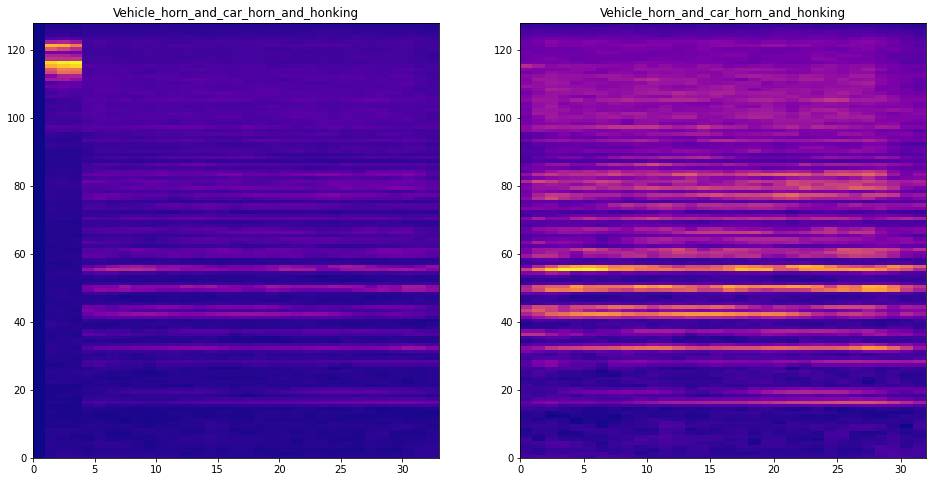

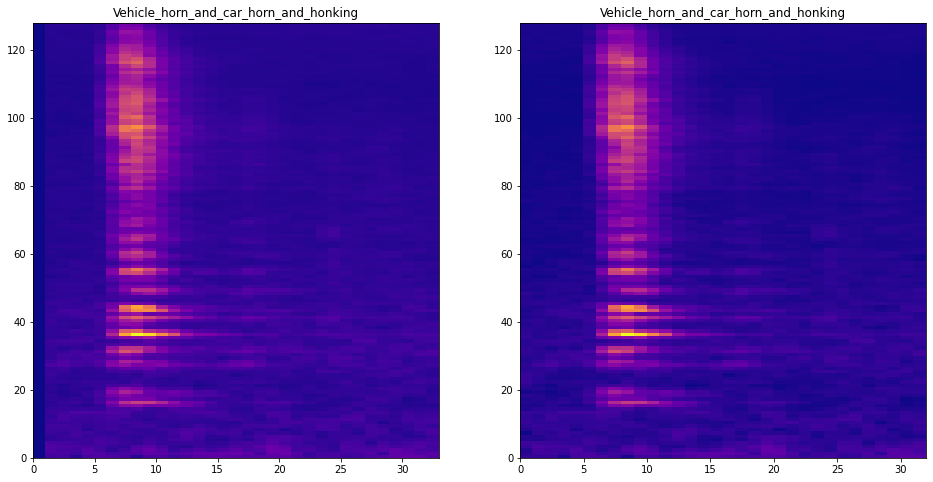

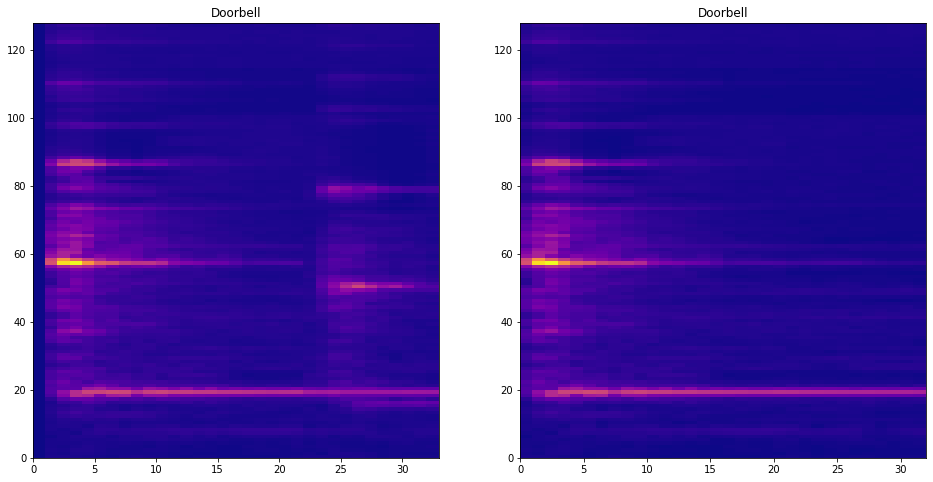

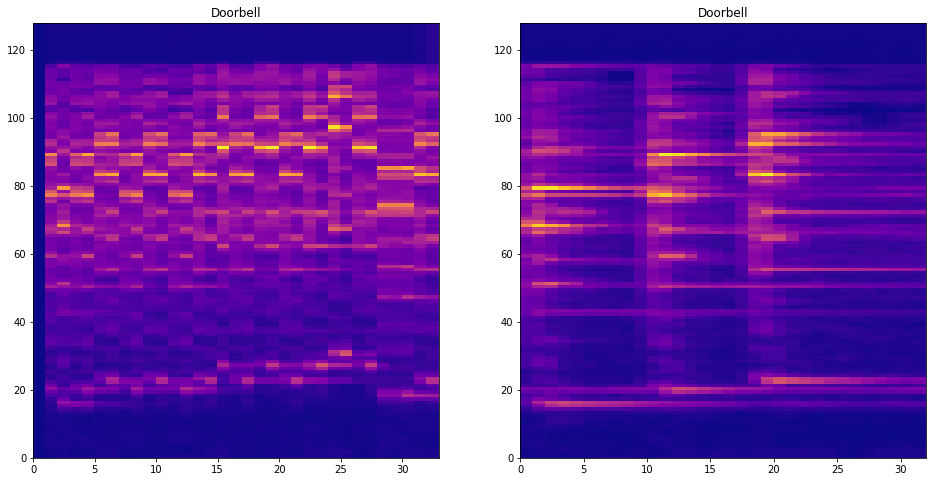

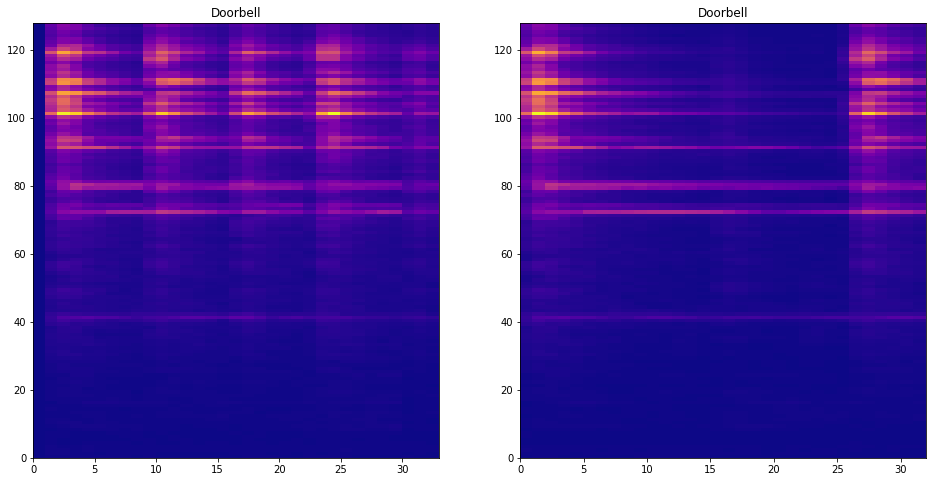

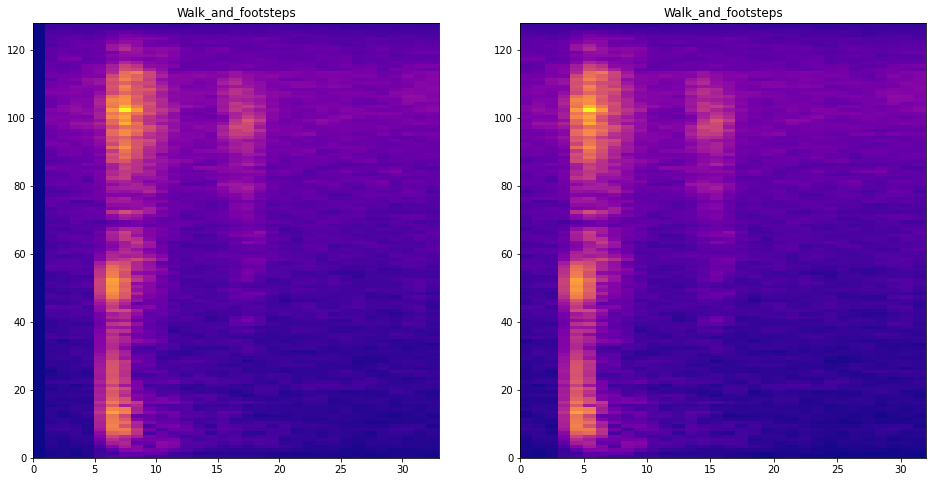

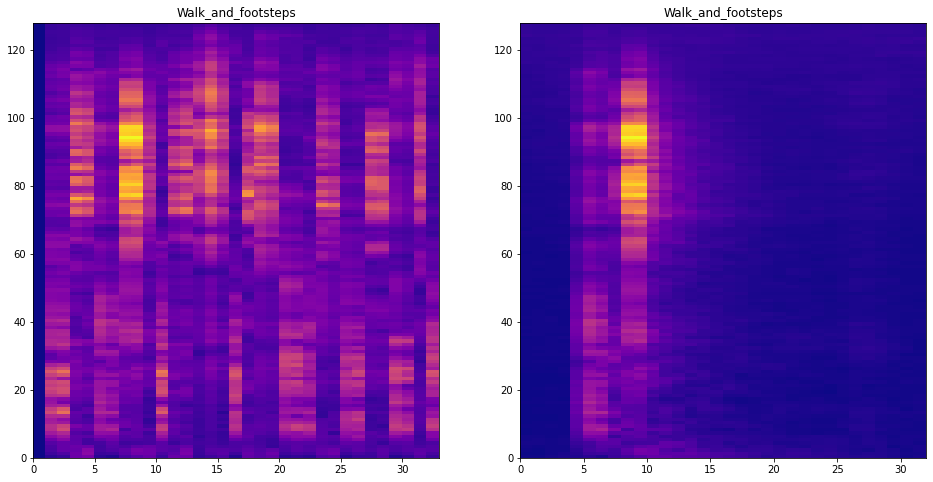

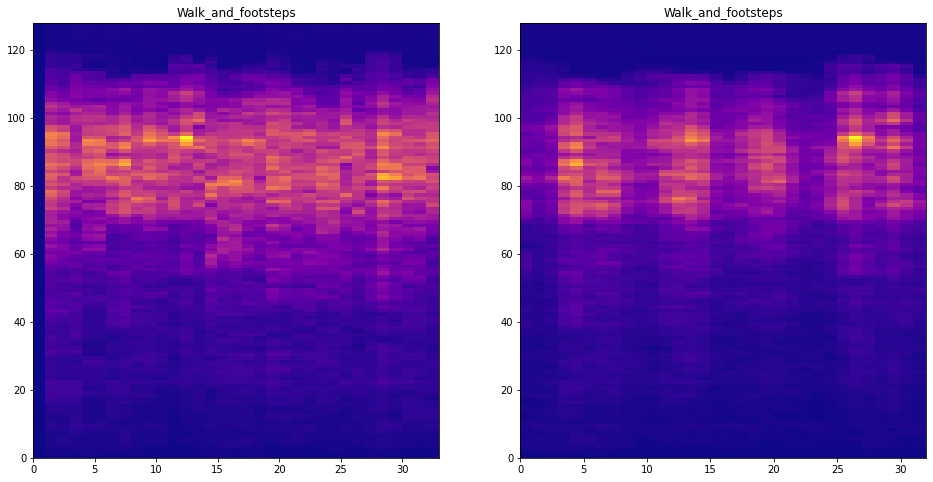

In [ ]:
for i in np.linspace(0,999,30) :
  i = int(i)
  r = reduceDim(X[i].copy())
  s = preprocess1(r, K= 32)
  t = preprocess2(r, 32)
  q = preprocess3(r, 32)
  # plotSpectrogram(True , r, Y[800] , s , Y[800])
  # plotSpectrogram(True , r, Y[800] , t , Y[800])
  plotSpectrogram(True , s, Y[i] , q , Y[i])

Label Encoding

In [23]:
def encoder(Y) :
  classes = list(enumerate(set(Y)))
  class_dict = {'Crying_and_sobbing': np.array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 
                'Vehicle_horn_and_car_horn_and_honking': np.array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), 
                'Doorbell': np.array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), 
                'Knock': np.array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), 
                'Siren': np.array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), 
                'Bark': np.array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), 
                'Walk_and_footsteps': np.array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), 
                'Shatter': np.array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]),
                'Meow': np.array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), 
                'Microwave_oven': np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])}
  # for i in range(10) :
  #   a = np.zeros(10)
  #   a[classes[i][0]] = 1
  #   class_dict[classes[i][1]] = a 
  # print(class_dict)
  labels = [] 
  for i in Y :
    labels.append(class_dict[i])
  return labels , class_dict

# Data Augmentation


1.   Introducing columns of zeros in the matrix
2.   Applying gaussian blur on the matrix


In [16]:
def line(mat , num) :
  width = mat.shape[1]
  mat = mat.T
  for j in range(num) :
      t = np.random.randint(low = 0 , high = width-1)
      mat[t] = np.zeros(128)
      
  return mat.T

def blur(mat , sigma = 0.5) :
  return gaussian_filter(mat , sigma)

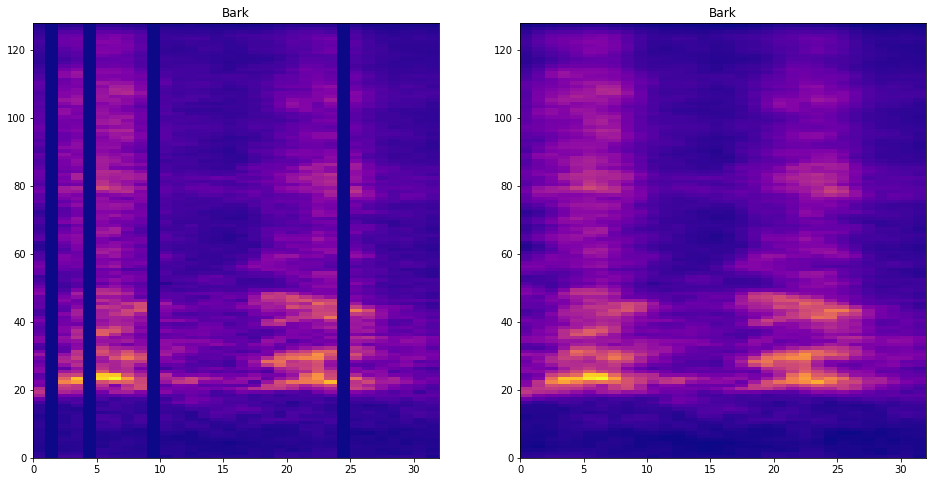

In [19]:
i = 32
r = reduceDim(X[i].copy())
#  s = preprocess1(r, K= 32)
#  t = preprocess2(r, 32)
q = preprocess3(r, 32)
plotSpectrogram(True , line(q.copy(),4), Y[i] , blur(q.copy()) , Y[i])


In [21]:
def nn_dataset(X , labels ,line_aug = True , num_lines = 4 , blur_aug = True , sigma = 0.55, method2 = False, method1 = True , method3=False , size = 32) :
  
  NN_dataset = []
  NN_labels = []
  for i in range(len(X)) :
    mat = reduceDim(X[i])
    if method2: 
      mat = preprocess2( mat, width = 32)
    if method1 :
      mat = preprocess1(mat , K = size-1)
    if method3 :
      mat = preprocess3( mat, width = 32)
    if line_aug :
      NN_dataset.append(addDim(line(mat,num_lines)))
      NN_labels.append(labels[i])
    if blur_aug :
      NN_dataset.append(addDim(blur(mat ,sigma)))
      NN_labels.append(labels[i])
    print(i)
  
  return np.array(NN_dataset) , np.array(NN_labels)   

# Models

In [ ]:
labels , class_dict = encoder(Y)
x,y = nn_dataset(X, labels, method1= True)

In [ ]:
np.save("/content/drive/MyDrive/mlsp/x_method3.npy" , x)
np.save("/content/drive/MyDrive/mlsp/y_method3.npy" , y)

In [54]:
xtrain, xtest , ytrain, ytest = train_test_split(x,y,test_size = 0.05 , random_state = 2002)

## Basic Functions

In [27]:
def plotLoss(epochs ,history) :

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()



Note : The functions recall, precision, f1 have been refered from StackOver flow website.

In [28]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## DNN

In [ ]:
dnn = Sequential()
dnn.add(layers.Flatten(input_shape = (128,32,1,)))
dnn.add(layers.Dense(128*32 , activation = 'relu' ))
dnn.add(layers.Dropout(0.2))
dnn.add(layers.Dense(1024 , activation = 'relu'))
dnn.add(layers.Dropout(0.2))
dnn.add(layers.Dense(512 , activation = 'relu'))
dnn.add(layers.Dense(128 , activation = 'relu'))
dnn.add(layers.Dense(64 , activation = 'relu'))
dnn.add(layers.Dense(10 , activation = 'softmax'))
dnn.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 4096)              0         
                                                                 
 dense_29 (Dense)            (None, 4096)              16781312  
                                                                 
 dropout_14 (Dropout)        (None, 4096)              0         
                                                                 
 dense_30 (Dense)            (None, 1024)              4195328   
                                                                 
 dropout_15 (Dropout)        (None, 1024)              0         
                                                                 
 dense_31 (Dense)            (None, 512)               524800    
                                                                 
 dense_32 (Dense)            (None, 128)              

In [ ]:
dnn.compile(optimizer='rmsprop', loss= 'categorical_crossentropy' , metrics=['accuracy' , f1_m ,recall_m,precision_m])

In [ ]:
dnn_path = "/content/drive/MyDrive/mlsp/a1_dnn_model_2.h5"

In [ ]:
dnn_history = dnn.fit(
    x = xtrain , y = ytrain ,
    epochs = 100 ,
    steps_per_epoch = 5,
    validation_split = 0.3,
    batch_size = 32,
)

Epoch 1/100
5/5 [==============================] - 1s 144ms/step - loss: 180.0566 - accuracy: 0.1125 - f1_m: 0.1052 - recall_m: 0.1000 - precision_m: 0.1289 - val_loss: 20.4670 - val_accuracy: 0.0750 - val_f1_m: 0.0755 - val_recall_m: 0.0750 - val_precision_m: 0.0760
Epoch 2/100
5/5 [==============================] - 0s 28ms/step - loss: 12.1113 - accuracy: 0.1000 - f1_m: 0.0898 - recall_m: 0.0812 - precision_m: 0.1061 - val_loss: 4.6963 - val_accuracy: 0.1500 - val_f1_m: 0.0557 - val_recall_m: 0.0333 - val_precision_m: 0.1855
Epoch 3/100
5/5 [==============================] - 0s 34ms/step - loss: 3.8870 - accuracy: 0.0938 - f1_m: 0.0193 - recall_m: 0.0125 - precision_m: 0.0432 - val_loss: 2.3853 - val_accuracy: 0.2083 - val_f1_m: 0.0272 - val_recall_m: 0.0146 - val_precision_m: 0.2111
Epoch 4/100
5/5 [==============================] - 0s 26ms/step - loss: 2.4266 - accuracy: 0.1937 - f1_m: 0.0572 - recall_m: 0.0312 - precision_m: 0.4500 - val_loss: 2.0830 - val_accuracy: 0.3208 - val_f

In [ ]:
dnn.save(dnn_path)

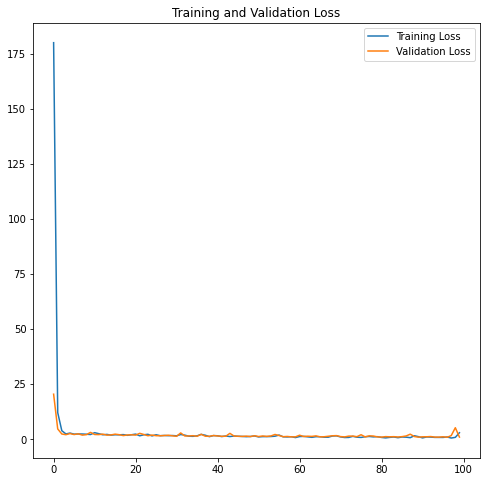

In [ ]:
plotLoss(100, dnn_history)

In [ ]:
dnn.evaluate(x= xtest , y=ytest)

13/13 [==============================] - 0s 4ms/step - loss: 1.1140 - accuracy: 0.6900 - f1_m: 0.6833 - recall_m: 0.5625 - precision_m: 0.8830


[1.1140364408493042,
 0.6899999976158142,
 0.6832963228225708,
 0.5625,
 0.882989764213562]

##**CNN**

In [29]:
def cnn_model() :
  cnn = Sequential()
  cnn.add(layers.Conv2D(16,(3,3),(2,2), padding = 'same' , activation = 'relu' ,input_shape = (128,32,1,)))
  cnn.add(layers.MaxPool2D())
  cnn.add(layers.Conv2D(32 , (3,3) ,padding = 'same' , activation = 'relu'))
  cnn.add(layers.MaxPool2D())
  cnn.add(layers.Conv2D(64 , (3,3) ,(2,2), padding = 'same' , activation = 'relu'))
  cnn.add(layers.Conv2D(64 , (3,3) , padding = 'same'))
  cnn.add(layers.MaxPool2D())
  cnn.add(layers.Flatten())
  cnn.add(layers.Dense(128 , activation = 'relu'))
  cnn.add(layers.Dense(10 , activation = 'softmax'))
  cnn.summary()
  return cnn

In [60]:
cnn = cnn_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 64, 16, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 8, 16)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 8, 32)         4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 4, 32)        0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 2, 64)          18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 2, 64)         

In [61]:
cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss= 'categorical_crossentropy' , metrics=['accuracy' ,f1_m,precision_m,recall_m])

In [63]:
history = cnn.fit(
    x= xtrain, y = ytrain,
    validation_split= 0.3, 
    epochs = 5,
    steps_per_epoch = 25,
    batch_size = 32,
)

Epoch 1/5
25/25 [==============================] - 1s 46ms/step - loss: 0.2941 - accuracy: 0.9600 - f1_m: 0.9098 - precision_m: 0.9196 - recall_m: 0.9010 - val_loss: 0.5492 - val_accuracy: 0.9140 - val_f1_m: 0.8615 - val_precision_m: 0.8842 - val_recall_m: 0.8409
Epoch 2/5
25/25 [==============================] - 1s 36ms/step - loss: 0.2575 - accuracy: 0.9580 - f1_m: 0.9310 - precision_m: 0.9343 - recall_m: 0.9281 - val_loss: 0.5554 - val_accuracy: 0.9070 - val_f1_m: 0.8447 - val_precision_m: 0.8631 - val_recall_m: 0.8276
Epoch 3/5
25/25 [==============================] - 1s 36ms/step - loss: 0.2926 - accuracy: 0.9575 - f1_m: 0.9117 - precision_m: 0.9163 - recall_m: 0.9078 - val_loss: 0.5259 - val_accuracy: 0.9070 - val_f1_m: 0.8643 - val_precision_m: 0.8822 - val_recall_m: 0.8478
Epoch 4/5
25/25 [==============================] - 1s 36ms/step - loss: 0.2951 - accuracy: 0.9580 - f1_m: 0.9134 - precision_m: 0.9190 - recall_m: 0.9083 - val_loss: 0.6239 - val_accuracy: 0.8754 - val_f1_m: 

In [ ]:
cnn.save('/content/drive/MyDrive/mlsp/cnn_final2.h5')


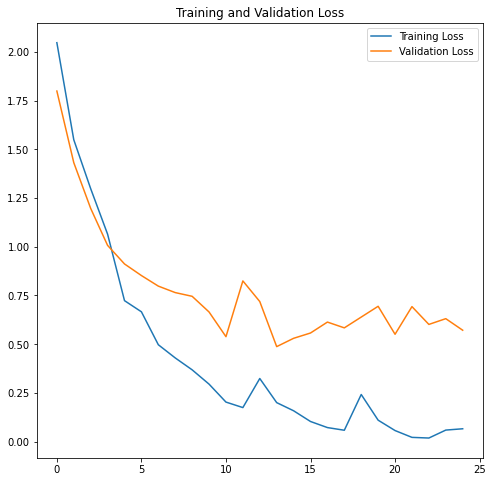

In [33]:
plotLoss(25,history)

# Testing

In [64]:
score = cnn.evaluate(
    x = xtest,
    y = ytest,
    batch_size = 32
)

4/4 [==============================] - 0s 9ms/step - loss: 0.6243 - accuracy: 0.8700 - f1_m: 0.8935 - precision_m: 0.9152 - recall_m: 0.8732


In [ ]:
x,y = nn_dataset(X, labels, method=1 , sigma = 0.6 , num_lines = 6 , size = 32)

In [ ]:
score_custom = cnn.evaluate(
    x = x , y= y
)

63/63 [==============================] - 0s 4ms/step - loss: 2.4918 - accuracy: 0.7425 - f1_m: 0.7412 - precision_m: 0.7468 - recall_m: 0.7361


In [ ]:
score_custom_dnn = dnn.evaluate(
    x = x , 
    y= y
)

63/63 [==============================] - 0s 4ms/step - loss: 1.5403 - accuracy: 0.5535 - f1_m: 0.4938 - recall_m: 0.3948 - precision_m: 0.7189


In [42]:
x1  = np.load('/content/drive/MyDrive/mlsp/x_method3.npy')
y1 = np.load('/content/drive/MyDrive/mlsp/y_method3.npy')


In [44]:
y = cnn.predict(x=x1)

In [65]:
cnn.evaluate(x= x1, y= y1)

63/63 [==============================] - 1s 9ms/step - loss: 1.0742 - accuracy: 0.7555 - f1_m: 0.7453 - precision_m: 0.7686 - recall_m: 0.7252


[1.0741517543792725,
 0.7555000185966492,
 0.7452574372291565,
 0.768561065196991,
 0.7251983880996704]

In [91]:
x1train, x1test , y1train, y1test = train_test_split(x1,y1,test_size = 0.1 , random_state = 2002)


In [92]:
history = cnn.fit(
    x= x1train, y = y1train,
    validation_split= 0.3, 
    epochs = 15,
    steps_per_epoch = 25,
    batch_size = 32,
)

Epoch 1/15
25/25 [==============================] - 1s 43ms/step - loss: 0.6216 - accuracy: 0.8363 - f1_m: 0.8267 - precision_m: 0.8684 - recall_m: 0.7912 - val_loss: 0.4192 - val_accuracy: 0.8907 - val_f1_m: 0.8670 - val_precision_m: 0.9348 - val_recall_m: 0.8099
Epoch 2/15
25/25 [==============================] - 1s 35ms/step - loss: 0.3750 - accuracy: 0.9115 - f1_m: 0.9074 - precision_m: 0.9322 - recall_m: 0.8850 - val_loss: 0.3103 - val_accuracy: 0.9167 - val_f1_m: 0.9184 - val_precision_m: 0.9466 - val_recall_m: 0.8929
Epoch 3/15
25/25 [==============================] - 1s 35ms/step - loss: 0.2452 - accuracy: 0.9262 - f1_m: 0.9261 - precision_m: 0.9465 - recall_m: 0.9075 - val_loss: 0.2683 - val_accuracy: 0.9389 - val_f1_m: 0.9358 - val_precision_m: 0.9504 - val_recall_m: 0.9223
Epoch 4/15
25/25 [==============================] - 1s 34ms/step - loss: 0.1767 - accuracy: 0.9436 - f1_m: 0.9445 - precision_m: 0.9600 - recall_m: 0.9300 - val_loss: 0.2501 - val_accuracy: 0.9352 - val_f1

In [93]:
cnn.evaluate(x= x1test , y = y1test)

7/7 [==============================] - 0s 8ms/step - loss: 0.4432 - accuracy: 0.9400 - f1_m: 0.9508 - precision_m: 0.9554 - recall_m: 0.9464


[0.4432304799556732,
 0.9399999976158142,
 0.9508219361305237,
 0.9553571343421936,
 0.9464285969734192]

In [73]:
reverse_class = {
                 1 : 'Crying_and_sobbing', 
                 2 : 'Vehicle_horn_and_car_horn_and_honking', 
                 3 : 'Doorbell', 
                 4 : 'Knock', 
                 5 : 'Siren', 
                 6 :'Bark', 
                 7 : 'Walk_and_footsteps', 
                 8 : 'Shatter',
                 9 : 'Meow', 
                 10 : 'Microwave_oven'
}

In [78]:
print(reverse_class[1])


Crying_and_sobbing


In [80]:
cnn.predict(x = x1test)

array([[4.4301833e-06, 1.0741988e-05, 3.3418971e-06, ..., 5.6441566e-21,
        5.6324586e-07, 1.1221920e-20],
       [3.8417596e-14, 3.7770117e-12, 8.9707278e-13, ..., 1.9174278e-17,
        1.0025829e-13, 9.9999988e-01],
       [1.1027725e-07, 5.3899987e-07, 6.8141550e-09, ..., 1.4111873e-07,
        5.8978850e-07, 1.9865619e-01],
       ...,
       [1.3463946e-07, 1.0656674e-08, 8.4213298e-06, ..., 1.5182998e-13,
        4.5902198e-09, 9.7585806e-09],
       [5.5370751e-15, 1.8506998e-17, 9.8839644e-14, ..., 1.5116512e-12,
        2.5144714e-11, 9.9997580e-01],
       [9.8621017e-01, 7.7403830e-03, 1.6482458e-04, ..., 3.6982500e-10,
        7.2502624e-04, 1.9273917e-03]], dtype=float32)

In [ ]:
y_pred1 = []
y_pred3 = []
x_test = []
path1 = "/content/drive/MyDrive/mlsp/test"
id = os.listdir(path1)
i = 0
for name in id :
  print(i)
  i +=1
  file = os.path.join(path1,name)
  mat = np.load(file)
  mat = reduceDim(mat)
  mat = preprocess1(mat.copy(),32)
  mat = addDim(mat)
  x_test.append(mat)
  



In [82]:
x_test = np.array(x_test)

In [84]:
y_pred = cnn.predict(x = x_test )

In [87]:
print(y_pred[0])

[4.4151936e-27 2.0256113e-30 1.2230016e-17 2.4001591e-13 1.9316648e-23
 7.9499618e-20 2.0318482e-12 6.6230155e-26 2.1590523e-21 1.0000000e+00]


In [ ]:
y_pred1 = []
y_pred3 = []
x_test3 = []
path1 = "/content/drive/MyDrive/mlsp/test"
id = os.listdir(path1)
i = 0
for name in id :
  print(i)
  i +=1
  file = os.path.join(path1,name)
  mat = np.load(file)
  mat = reduceDim(mat)
  mat = preprocess3(mat.copy(),32)
  mat = addDim(mat)
  x_test3.append(mat)
  


In [90]:
np.save("/content/drive/MyDrive/mlsp/test.npy" , x_test3)

In [96]:
x_test3 = np.array(x_test3)

In [97]:
print(x_test3.shape)

(201, 128, 32, 1)


In [98]:
y_pred3 = cnn.predict(x = x_test3)

In [103]:
print(y_pred3[200])

[5.27321166e-15 2.08849837e-17 1.37024032e-17 1.00000000e+00
 1.39135885e-14 3.39351186e-10 2.71587919e-10 2.73208166e-19
 7.90210952e-10 1.60331048e-19]


In [104]:
print(y_pred[200])

[4.0232236e-20 8.7120486e-23 7.8259590e-21 1.0000000e+00 1.3048517e-17
 3.8113054e-13 5.2615102e-14 1.0336306e-22 4.0150272e-17 1.0946070e-18]


In [106]:
pred = []
for y1 in y_pred3 :
  t = y1
  t = list(enumerate(t))
  t.sort(key = lambda a : a[1])
  t.reverse()
  p = t[0][0]
  p+=1
  pred.append(p)

In [108]:
print(reverse_class[pred[0]])

Microwave_oven


In [109]:
predictions = []
for p in pred :
  predictions.append(reverse_class[p])

In [110]:
print(predictions)

['Microwave_oven', 'Microwave_oven', 'Microwave_oven', 'Microwave_oven', 'Microwave_oven', 'Microwave_oven', 'Microwave_oven', 'Knock', 'Microwave_oven', 'Microwave_oven', 'Microwave_oven', 'Siren', 'Meow', 'Meow', 'Meow', 'Meow', 'Knock', 'Meow', 'Meow', 'Meow', 'Knock', 'Meow', 'Microwave_oven', 'Microwave_oven', 'Bark', 'Microwave_oven', 'Meow', 'Meow', 'Meow', 'Bark', 'Meow', 'Bark', 'Meow', 'Knock', 'Knock', 'Vehicle_horn_and_car_horn_and_honking', 'Doorbell', 'Bark', 'Siren', 'Shatter', 'Shatter', 'Knock', 'Siren', 'Shatter', 'Crying_and_sobbing', 'Shatter', 'Shatter', 'Bark', 'Siren', 'Microwave_oven', 'Shatter', 'Shatter', 'Shatter', 'Doorbell', 'Shatter', 'Shatter', 'Knock', 'Microwave_oven', 'Bark', 'Microwave_oven', 'Bark', 'Microwave_oven', 'Shatter', 'Walk_and_footsteps', 'Microwave_oven', 'Microwave_oven', 'Microwave_oven', 'Shatter', 'Knock', 'Microwave_oven', 'Microwave_oven', 'Microwave_oven', 'Microwave_oven', 'Walk_and_footsteps', 'Crying_and_sobbing', 'Doorbell', 'V

In [111]:
df = pd.DataFrame(list(zip(id, predictions)),columns =['fileid', 'prediction'])

In [112]:
df.to_csv("/content/drive/MyDrive/mlsp/predictions.csv")